## Aesthetic scoring

In [1]:
import cv2
from PIL import Image

def extract_specific_frame(video_path, frame_position, output_image=None):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print("Error opening video file")
        return

    # Get the total number of frames
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the frame index based on the position
    if frame_position == 'middle':
        frame_index = total_frames // 2
    elif frame_position == 'last':
        frame_index = total_frames - 1
    else:  # 'first' or any other input defaults to the first frame
        frame_index = 0

    # Set the current frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)

    # Read the frame
    ret, frame = cap.read()
    if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = Image.fromarray(frame)
        if output_image is not None:
            # Save the frame as an image
            cv2.imwrite(output_image, frame)
    else:
        print(f"Error reading the {frame_position} frame")

    # Release the video capture object
    cap.release()

    return frame

In [ ]:
video_clip_path = 'v_BasketballDunk_g14_c06-Scene-002.mp4'  

# Extract and save the first, middle, and last frames
first_frame = extract_specific_frame(video_clip_path, 'first')
middle_frame = extract_specific_frame(video_clip_path, 'middle')
last_frame = extract_specific_frame(video_clip_path, 'last')

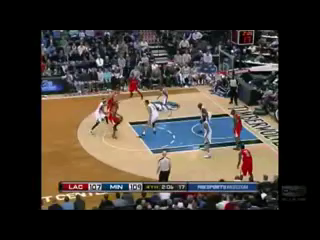

In [2]:
first_frame

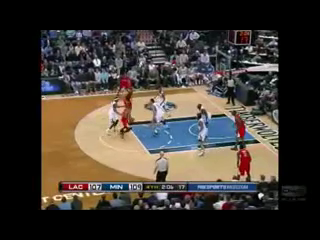

In [3]:
middle_frame

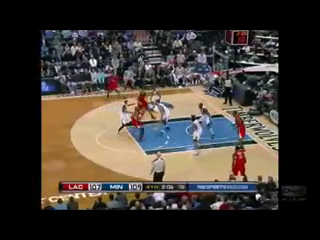

In [4]:
last_frame

In [5]:
# !wget --content-disposition https://github.com/kvablack/ddpo-pytorch/raw/main/ddpo_pytorch/assets/sac+logos+ava1-l14-linearMSE.pth -q

In [6]:
# Copied from https://github.com/kvablack/ddpo-pytorch/blob/main/ddpo_pytorch/aesthetic_scorer.py

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2" 

import torch
import torch.nn as nn
from transformers import CLIPModel, CLIPProcessor

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(768, 1024),
            nn.Dropout(0.2),
            nn.Linear(1024, 128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.Dropout(0.1),
            nn.Linear(64, 16),
            nn.Linear(16, 1),
        )

    @torch.no_grad()
    def forward(self, embed):
        return self.layers(embed)


class AestheticScorer(torch.nn.Module):
    def __init__(self, dtype):
        super().__init__()
        self.clip = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
        self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
        
        self.mlp = MLP()
        state_dict = torch.load("sac+logos+ava1-l14-linearMSE.pth")
        self.mlp.load_state_dict(state_dict)
        self.dtype = dtype
        self.eval()

    @torch.no_grad()
    def __call__(self, images):
        device = next(self.parameters()).device
        inputs = self.processor(images=images, return_tensors="pt")
        inputs = {k: v.to(self.dtype).to(device) for k, v in inputs.items()}
        embed = self.clip.get_image_features(**inputs)
        # normalize embedding
        embed = embed / torch.linalg.vector_norm(embed, dim=-1, keepdim=True)
        return self.mlp(embed).squeeze(1)

In [7]:
aesthetic_scorer = AestheticScorer(dtype=torch.float32)

index_map = {
    0: "start",
    1: "middle",
    2: "last"
}

aesthetic_dict = {}
for i, frame in enumerate([first_frame, middle_frame, last_frame]):
    score = aesthetic_scorer(frame)
    aesthetic_dict[index_map[i]] = float(score)

print(aesthetic_dict)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


{'start': 4.504028797149658, 'middle': 4.590480804443359, 'last': 4.694556713104248}


In [8]:
del aesthetic_scorer

## Similarity

In [14]:
# From https://huggingface.co/docs/transformers/model_doc/clip

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

similarity_dict = {}
for i, frame in enumerate([first_frame, middle_frame, last_frame]):
    # Caption from `video_preprocessing_captioning.ipynb`.
    inputs = processor(
        text=["A basketball player in a group of men dribbles towards the basket on a court."],
        images=frame,
        return_tensors="pt",
        padding=True
    )
    
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
    final_score = float(logits_per_image.softmax(dim=1).squeeze())
    similarity_dict[index_map[i]] = final_score

print(similarity_dict)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


{'start': 1.0, 'middle': 1.0, 'last': 1.0}
